In [7]:
# %pip install --upgrade scikit-learn

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

df = pd.read_csv("combined_data_clean.csv")
df.columns = df.columns.str.strip()

print("Columns:", df.columns.tolist())
print("Shape:", df.shape)


Columns: ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HST', 'AST', 'B365H', 'B365A', 'BWH', 'BWA', 'PSH', 'PSA', 'WHH', 'WHA', 'MaxH', 'MaxA', 'AvgH', 'AvgA', 'AHh', 'B365CH', 'B365CA', 'BWCH', 'PSCH', 'PSCA', 'WHCH', 'MaxCH', 'MaxCA', 'AvgCH', 'AvgCA', 'AHCh', 'IWH', 'IWA', 'VCH', 'VCA', 'FTREncoded', 'FTR']
Shape: (3863, 36)


In [8]:
betting_keywords = ['B365', 'BW', 'PS', 'WH', 'Max', 'Avg', 'VC', 'IW', 'AH']

df = df.drop(
    columns=[c for c in df.columns if any(k in c for k in betting_keywords)]
)

df.columns

Index(['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HST', 'AST', 'FTREncoded', 'FTR'], dtype='object')

In [9]:
rename_map = {
    'FTHG': 'Full Time Home Goals',
    'FTAG': 'Full Time Away Goals',
    'FTR' : 'Full Time Result',
    'HTHG': 'Half Time Home Goals',
    'HTAG': 'Half Time Away Goals',
    'HST' : 'Home Shots on Target',
    'AST' : 'Away Shots on Target'
}
df = df.rename(columns=rename_map)
df.columns

Index(['Full Time Home Goals', 'Full Time Away Goals', 'Half Time Home Goals',
       'Half Time Away Goals', 'Home Shots on Target', 'Away Shots on Target',
       'FTREncoded', 'Full Time Result'],
      dtype='object')

In [10]:
from sklearn.preprocessing import LabelEncoder

X = df[
    [
        'Half Time Home Goals',
        'Half Time Away Goals',
        'Home Shots on Target',
        'Away Shots on Target'
    ]
]
y = df['Full Time Result'].astype(str).str.strip().str.upper()
y = y.map({'H':0, 'D':1, 'A':2})
print(y.value_counts(dropna=False))
print("NaNs after mapping:", y.isna().sum())


Full Time Result
0    1736
2    1105
1    1022
Name: count, dtype: int64
NaNs after mapping: 0


In [11]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# In deployment environment
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# assume X_train, y_train prepared
imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.fit_transform(X_test)
rf_model = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train_imp, y_train)
pred = rf_model.predict(X_test_imp)  # <- X_test_imp is your imputed test set

joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(imputer, "imputer.pkl")


['imputer.pkl']

In [12]:
labels = [0, 1, 2]  # H, D, A
print("Confusion Matrix:\n", confusion_matrix(y_test, pred, labels=labels))
print("\nClassification Report:\n", classification_report(y_test, pred, labels=labels, target_names=['Home Win','Draw','Away Win'], digits=4))


Confusion Matrix:
 [[242  89  16]
 [ 61  85  59]
 [ 18  64 139]]

Classification Report:
               precision    recall  f1-score   support

    Home Win     0.7539    0.6974    0.7246       347
        Draw     0.3571    0.4146    0.3837       205
    Away Win     0.6495    0.6290    0.6391       221

    accuracy                         0.6028       773
   macro avg     0.5869    0.5803    0.5825       773
weighted avg     0.6188    0.6028    0.6097       773



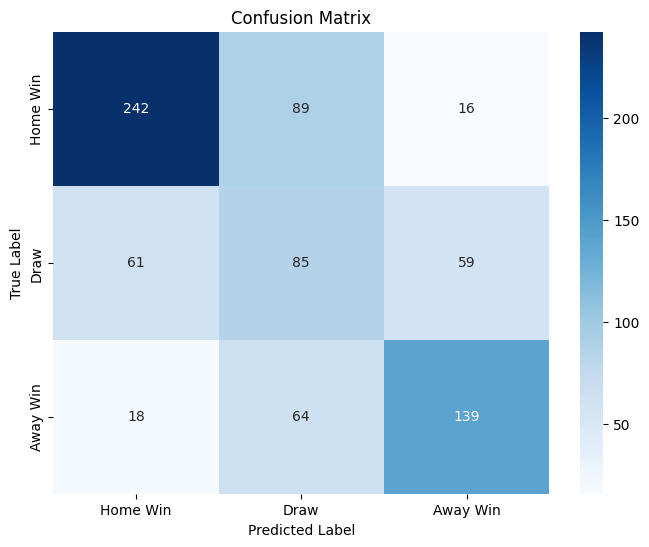

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Labels: 0=H, 1=D, 2=A
labels = [0, 1, 2]
class_names = ['Home Win', 'Draw', 'Away Win']

conf_matrix = confusion_matrix(y_test, pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [14]:
import joblib

joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(imputer, "imputer.pkl")

print("Model saved successfully as rf_model.pkl and imputer.pkl")

Model saved successfully as rf_model.pkl and imputer.pkl
